## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import collections

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_model, save_obj, load_model, load_obj, get_model_dictionary
from LOW_LEVEL_UTILITIES.utilities import dataset_in_memory, check_datasets
from simulation_dictionary import SimulationDictionary 
#from VAE.vae_model import VAE

import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceGraph_ELBO, TraceEnum_ELBO, config_enumerate #, JitTraceEnum_ELBO, 
from pyro.optim import Adam, Adamax, SGD

def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)

## Generate simulation parameters

In [2]:
#### Create the simulation parameters dictionary

params=SimulationDictionary()
#write_dir = "/home/ldalessi/spacetx-research/parallel_enum_annealing_v2/ARCHIVE/"
#params=load_obj(write_dir,"params_disk_v1")
params['UNET.N_prediction_maps']=1
print(params)
params.check_consistency()

from VAE.vae_parts import Inference
inference=Inference(params)

{'SD.width': 28, 'SD.dim_h1': -1, 'SD.dim_h2': -1, 'ZWHAT.dim': 10, 'ZMASK.dim': 10, 'ANNEALING.protocol': 'Linear_Decay', 'ANNEALING.prob_initial': 1.0, 'ANNEALING.prob_final': 1e-05, 'ANNEALING.begin': 100, 'ANNEALING.duration': 200, 'PRIOR.n_max_objects': 6, 'PRIOR.min_object_size': 15, 'PRIOR.max_object_size': 35, 'PRIOR.expected_object_size': 20, 'IMG.size_raw_image': 80, 'IMG.ch_in_description': ['DAPI'], 'UNET.N_max_pool': 4, 'UNET.N_up_conv': 2, 'UNET.CH_after_first_two_conv': 32, 'UNET.N_prediction_maps': 1, 'NMS.p_threshold': 0.0, 'NMS.overlap_threshold': 0.2, 'use_cuda': False}


## Generate (if necessary) and load the synthetic data

In [3]:
disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"
mMNIST_data_dir = "/home/ldalessi/DATA/MULTI_MNIST/"
disk_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/MULTI_DISK/"
mMNIST_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/MULTI_MNIST/"

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_small",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_small",use_cuda=params['use_cuda'])

train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_small",use_cuda=params['use_cuda'])
test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_small",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_with_bg",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_with_bg",use_cuda=params['use_cuda'])

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=params['use_cuda'])
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=params['use_cuda'])

## Check the train and test dataset

Dataset lenght: 1000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


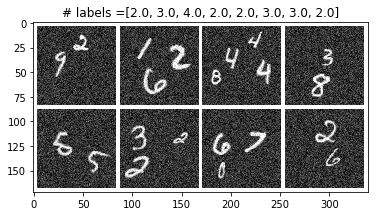

In [4]:
check_datasets(train_dataset)

Dataset lenght: 1000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


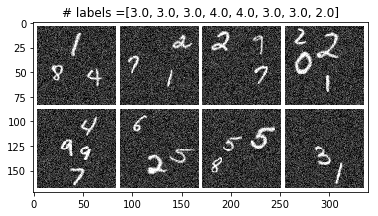

In [5]:
check_datasets(test_dataset)

1000
torch.Size([1000, 484])


Text(0.5,0,'Average intensity in box of size 15')

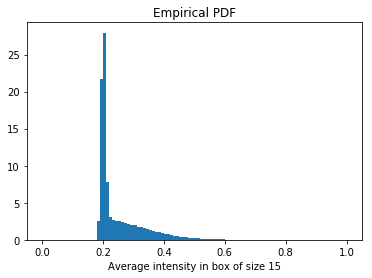

In [6]:
size=15
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
print(len(r))
print(r.shape)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

1000
torch.Size([1000, 225])


Text(0.5,0,'Average intensity in box of size 35')

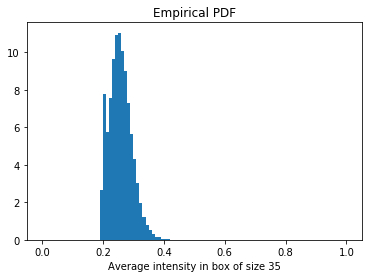

In [7]:
size=35
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
print(len(r))
print(r.shape)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

tensor(3.)


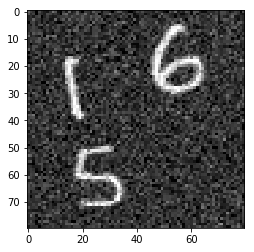

In [8]:
imgs_in, labels = train_dataset.load(128)
print(labels[0])
show_batch(imgs_in[:1])

Text(0.5,0,'pixel intensity')

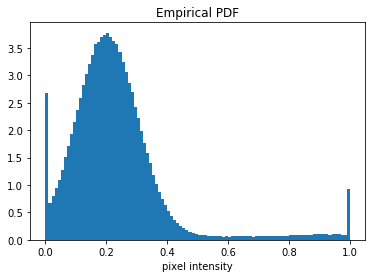

In [9]:
b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("pixel intensity")

### Helper function for training and evaluation

In [10]:
from PIL import Image, ImageDraw

def compute_intensity_brute_force(z_where,imgs):
    
    assert imgs.shape[0]==z_where.bx_dimfull.shape[0]
    batch_size,ch,w,h = imgs.shape
    x1 = torch.clamp((1+z_where.bx_dimfull-0.5*z_where.bw_dimfull).long(),min=0,max=w-1).squeeze(-1) 
    x3 = torch.clamp((1+z_where.bx_dimfull+0.5*z_where.bw_dimfull).long(),min=0,max=w-1).squeeze(-1) 
    y1 = torch.clamp((1+z_where.by_dimfull-0.5*z_where.bh_dimfull).long(),min=0,max=h-1).squeeze(-1) 
    y3 = torch.clamp((1+z_where.by_dimfull+0.5*z_where.bh_dimfull).long(),min=0,max=h-1).squeeze(-1) 
    area = (z_where.bw_dimfull*z_where.bh_dimfull).squeeze(-1) 
    
    batch_size,n_boxes = x1.shape
    r = torch.zeros((batch_size,n_boxes))
    for b in range(batch_size):
        for n in range(n_boxes):
            #print("b,n",b,n)
            r[b,n]=torch.sum(imgs[b,0,x1[b,n]:x3[b,n],y1[b,n]:y3[b,n]])/area[b,n]
            
    return r
    
def draw_batch_of_images_with_bb_only(z_where,width,height):
       
    # Exttract the probabilities for each box
    batch_size,n_boxes = z_where.prob.shape[:2]
    p = z_where.prob.view(batch_size,n_boxes,-1)
        
    # prepare the storage
    batch_bb_np    = np.zeros((batch_size,width,height,3)) # numpy storage for bounding box images
        
    # compute the coordinates of the bounding boxes and the probability of each box
    x1 = (z_where.bx_dimfull-0.5*z_where.bw_dimfull).view(batch_size,n_boxes,-1)
    x3 = (z_where.bx_dimfull+0.5*z_where.bw_dimfull).view(batch_size,n_boxes,-1)
    y1 = (z_where.by_dimfull-0.5*z_where.bh_dimfull).view(batch_size,n_boxes,-1)
    y3 = (z_where.by_dimfull+0.5*z_where.bh_dimfull).view(batch_size,n_boxes,-1)
    #print("cazzo",x1,x3,y1,y3)

    assert( len(x1.shape) == 3) 
    x1y1x3y3 = torch.cat((x1,y1,x3,y3),dim=-1)
                
    # draw the bounding boxes
    for b in range(batch_size):
        
        # Draw on PIL
        img = Image.new('RGB', (width,height), color=0)
        draw = ImageDraw.Draw(img)
        for i in range(n_boxes):
            #if(p[b,i,0]>0.0):
            draw.rectangle(x1y1x3y3[b,i,:].cpu().numpy(), outline='red', fill=None)
        batch_bb_np[b,...] = np.array(img.getdata(),np.uint8).reshape(width,height,3)

    # Transform np to torch, rescale from [0,255] to (0,1) 
    batch_bb_torch = torch.from_numpy(batch_bb_np).permute(0,3,2,1).float()/255 #permute(0,3,2,1) is CORRECT
    return batch_bb_torch.to(p.device)   

def rank(x,dim=-1):
    _, order = torch.sort(x,    dim=dim, descending=False)
    _, rank  = torch.sort(order,dim=dim, descending=False)
    return rank
        
def compute_average_intensity_in_box(imgs,z_where):
    """ Input batch of images: batch x ch x w x h
        z_where collections of [prob,bx,by,bw,bh]
        z_where.prob.shape = batch x n_box x 1 
        similarly for bx,by,bw,bh
        
        Output: 
        av_intensity = batch x n_box
    """
    
    # sum the channels, do cumulative sum in width and height
    cum = torch.cumsum(torch.cumsum(imgs,dim=-2),dim=-1)[:,0,:,:]
    assert len(cum.shape)==3
    print("cum.shape",cum.shape)
    batch_size, w, h = cum.shape 
    
    # compute the x1,y1,x3,y3
    x1 = torch.clamp((z_where.bx_dimfull-0.5*z_where.bw_dimfull).long(),min=0,max=w-1).squeeze(-1) 
    x3 = torch.clamp((z_where.bx_dimfull+0.5*z_where.bw_dimfull).long(),min=0,max=w-1).squeeze(-1) 
    y1 = torch.clamp((z_where.by_dimfull-0.5*z_where.bh_dimfull).long(),min=0,max=h-1).squeeze(-1) 
    y3 = torch.clamp((z_where.by_dimfull+0.5*z_where.bh_dimfull).long(),min=0,max=h-1).squeeze(-1) 
    
    # compute the area
    # Note that this way penalizes boxes that go out-of-bound
    # This is in contrast to area = (x3-x1)*(y3-y1) which does NOT penalize boxes out of bound
    area = (z_where.bw_dimfull*z_where.bh_dimfull).squeeze(-1) 

    # Make some checks
    assert x1.shape == x3.shape == y1.shape == y3.shape == area.shape
    assert len(area.shape)==2
    assert area.shape[0] == cum.shape[0]
    batch_size, n_boxes = area.shape
    
    # compute the total intensity in each box
    batch_index = torch.arange(0,batch_size).view(-1,1).expand(-1,n_boxes).to(x1.device)
    tot_intensity = cum[batch_index,x3,y3]-cum[batch_index,x1,y3]-cum[batch_index,x3,y1]+cum[batch_index,x1,y1]
    assert (batch_size, n_boxes) == tot_intensity.shape
   
    # return the average intensity
    return tot_intensity/area 

def select_top_boxes_by_prob(z_where_all,n_max_object):
    
    p_masked=z_where_all.prob.squeeze(-1)
    batch_size,n_boxes = p_masked.shape 
    p_top_k, top_k_indeces = torch.topk(p_masked, k=min(n_max_object,n_boxes), dim=-1, largest=True, sorted=True)
    batch_size, k = top_k_indeces.shape 
    batch_indeces = torch.arange(batch_size).unsqueeze(-1).expand(-1,k).to(top_k_indeces.device)
               
    # package the output
    return collections.namedtuple('z_where', 'prob bx_dimfull by_dimfull bw_dimfull bh_dimfull')._make(
            [p_masked.unsqueeze(-1)[batch_indeces,top_k_indeces],
             z_where_all.bx_dimfull[batch_indeces,top_k_indeces],
             z_where_all.by_dimfull[batch_indeces,top_k_indeces],
             z_where_all.bw_dimfull[batch_indeces,top_k_indeces],
             z_where_all.bh_dimfull[batch_indeces,top_k_indeces]])

### Instantiate Inference 

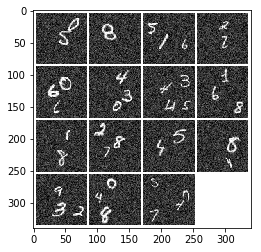

In [11]:
imgs_in = torch.zeros(2,1,80,80)

x1 = 65
x3 = 75
y1 = 5
y3 = 25
bx = int(0.5*(x1+x3))
by = int(0.5*(y1+y3))
bw = (x3-x1)
bh = (y3-y1)

imgs_in[:,:,x1:x3,y1:y3]=1
imgs_in[:,:,bx,by]=0
imgs_in, labels = train_dataset.load(15)


show_batch(imgs_in,npadding=4)

cum.shape torch.Size([15, 80, 80])


Text(0,0.5,'cumulative dist')

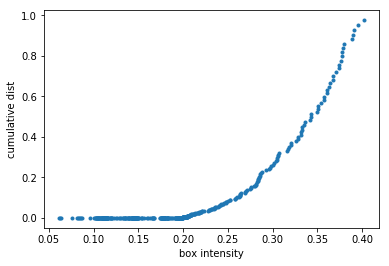

In [12]:
p_corr_factor=1

with torch.no_grad():
    batch_size,ch,width,height = imgs_in.shape
    z_where_all = inference.unet.forward(imgs_in)
    x = compute_average_intensity_in_box(imgs_in,z_where_all)
    highest_intensities, indices_of_high_intensity = torch.topk(x, k=2, dim=-1, largest=True, sorted=True)
    ranking = rank(x,dim=-1).float()/x.shape[-1]
    p_approx = ranking.pow(10)
    
    
    # weighted average of the prob by the inference netwrok and probs by the comulative 
    new_p = (1-p_corr_factor)*z_where_all.prob+p_corr_factor*p_approx.view_as(z_where_all.prob) 
    z_where_all = z_where_all._replace(prob=new_p)
        
    # NMS or TOP_K
    #z_where = inference.nms.forward(z_where_all)
    z_where = select_top_boxes_by_prob(z_where_all,6)

    
plt.plot(x.numpy()[0],p_approx.numpy()[0],'.')
plt.xlabel("box intensity")
plt.ylabel("cumulative dist")

In [13]:
###n_max_object = 10

###with torch.no_grad():
###   p_masked=p_approx.squeeze(-1)
###       
###   # select the top_k boxes by probability
###   batch_size,n_boxes = p_masked.shape
###   p_top_k, top_k_indeces = torch.topk(p_masked, k=min(n_max_object,n_boxes), dim=-1, largest=True, sorted=True)
###   batch_size, k = top_k_indeces.shape 
###   batch_indeces = torch.arange(batch_size).unsqueeze(-1).expand(-1,k).to(top_k_indeces.device)
###           
###           
###   # package the output
###   z_where = collections.namedtuple('z_where', 'prob bx_dimfull by_dimfull bw_dimfull bh_dimfull')._make(
###               [p_masked.unsqueeze(-1)[batch_indeces,top_k_indeces],
###                z_where_all.bx_dimfull[batch_indeces,top_k_indeces],
###                z_where_all.by_dimfull[batch_indeces,top_k_indeces],
###                z_where_all.bw_dimfull[batch_indeces,top_k_indeces],
###                z_where_all.bh_dimfull[batch_indeces,top_k_indeces]])

smart sum tensor([[0.4017, 0.3956]])
brute force sum tensor([[0.4017, 0.3956, 0.3905, 0.3899, 0.3891, 0.3796]])
tensor([[0.9753],
        [0.9511],
        [0.9275],
        [0.9044],
        [0.8818],
        [0.8597]])
bx 70 tensor([34.0798])
by 15 tensor([45.8821])
bw 10 tensor([26.3946])
bh 20 tensor([22.5479])


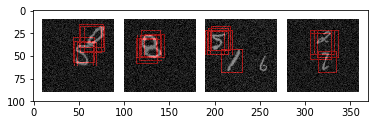

In [17]:
bb = draw_batch_of_images_with_bb_only(z_where,width,height)
imgs_with_bb = bb+imgs_in

print("smart sum",highest_intensities[:1])
r = compute_intensity_brute_force(z_where,imgs_in)
print("brute force sum",r[:1])

print(z_where.prob[0])
print("bx",bx,z_where.bx_dimfull[0,0])
print("by",by,z_where.by_dimfull[0,0])
print("bw",bw,z_where.bw_dimfull[0,0])
print("bh",bh,z_where.bh_dimfull[0,0])
show_batch(imgs_with_bb[:4])

In [25]:
cropped_imgs = inference.cropper.forward(z_where,imgs_in)
print(cropped_imgs.shape)

torch.Size([15, 6, 1, 28, 28])


torch.Size([15, 6, 1, 28, 28])


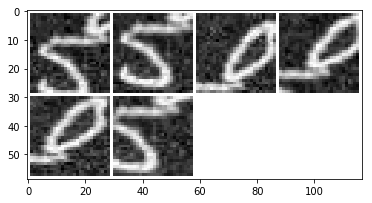

In [19]:
print(cropped_imgs.shape)
show_batch(cropped_imgs[0],npadding=1)

torch.Size([15, 1, 80, 80])


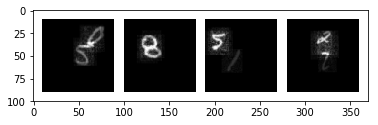

In [27]:
from CROPPER_UNCROPPER.cropper_uncropper import Uncropper, Cropper

batch_size,n_boxes = z_where.bx_dimfull.shape[:2]
#cropped_stuff = torch.ones(batch_size*n_boxes,1,28,28)
#cropped_stuff[:,:,14,14]=0
cropped_stuff = cropped_imgs.view(batch_size*n_boxes,1,28,28)
uncropper = Uncropper()
uncropped_imgs = uncropper.forward(z_where,cropped_stuff,width,height)
new_imgs = torch.sum(uncropped_imgs,dim=1)
    
print(new_imgs.shape)
show_batch(new_imgs[:4])

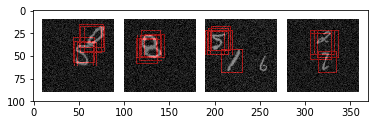

In [28]:
show_batch(imgs_with_bb[:4])